In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedShuffleSplit # Using the better splitter
import pandas as pd # For verification
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# --- Paths ---
PROCESSED_DATA_DIR = 'processed_data_cqt/' # <-- Point to the new CQT data folder
MODEL_SAVE_DIR = 'saved_models/'

# --- Model & Training Parameters ---
IMG_HEIGHT = 60    # <-- CQT height is 60 (n_bins from the CQT function)
IMG_WIDTH = 40     # <-- This should be consistent
NUM_CLASSES = 5    # <-- This should still be 5
BATCH_SIZE = 32
EPOCHS = 100 # Give it more epochs to learn

In [3]:
# Lists to hold our data and labels
spectrograms = []
labels = []
patient_ids = []

print("Loading processed CQT data...")
for filename in tqdm(os.listdir(PROCESSED_DATA_DIR)):
    if filename.endswith('.npy'):
        parts = filename.replace('.npy', '').split('-')
        label = parts[0]
        patient_id = parts[1]
        
        # Load the 2D CQT data
        spec = np.load(os.path.join(PROCESSED_DATA_DIR, filename))
        
        # --- THE FIX IS HERE ---
        # Add a "channel" dimension at the end to make it (60, 40, 1)
        spec = np.expand_dims(spec, axis=-1)
        
        spectrograms.append(spec)
        labels.append(label)
        patient_ids.append(patient_id)

# Convert lists to numpy arrays
X = np.array(spectrograms)
y = np.array(labels)
patients = np.array(patient_ids)

print(f"\nLoaded {len(X)} samples.")
print(f"Shape of our data (X): {X.shape}") # Should be (464, 60, 40, 1)

Loading processed CQT data...


100%|██████████| 464/464 [00:00<00:00, 5555.21it/s]


Loaded 464 samples.
Shape of our data (X): (464, 60, 40, 1)


In [4]:
# Convert text labels to integer labels (e.g., 'AR' -> 0, 'MS' -> 1)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert integer labels to one-hot encoded vectors
y_categorical = to_categorical(y_encoded, num_classes=NUM_CLASSES)

print("Original label:", y[0])
print("Encoded label:", y_encoded[0])
print("Categorical label:", y_categorical[0])

Original label: MS
Encoded label: 3
Categorical label: [0. 0. 0. 1. 0.]


In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd

print("--- Performing a Stratified, Patient-Aware Split ---")

# We need the integer-encoded labels to stratify correctly
y_encoded = label_encoder.transform(y)

# We want to stratify by disease class, but split by patient ID.
# This is tricky. We'll create a mapping from patient ID to their disease class.
# We'll assume one patient has one condition.
patient_to_disease = {}
for patient_id, disease_class in zip(patients, y_encoded):
    if patient_id not in patient_to_disease:
        patient_to_disease[patient_id] = disease_class

# Create lists of unique patients and their corresponding primary disease
unique_patients = list(patient_to_disease.keys())
patient_diseases = list(patient_to_disease.values())

# Now use StratifiedShuffleSplit on the PATIENTS
# This ensures the class distribution is similar in train/val sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_patient_indices, val_patient_indices in sss.split(unique_patients, patient_diseases):
    train_patients = np.array(unique_patients)[train_patient_indices]
    val_patients = np.array(unique_patients)[val_patient_indices]

# Create masks to select all data based on the patient split
train_indices = np.where(np.isin(patients, train_patients))[0]
val_indices = np.where(np.isin(patients, val_patients))[0]

# Use the indices to create the final data splits
X_train, X_val = X[train_indices], X[val_indices]
y_train, y_val = y_categorical[train_indices], y_categorical[val_indices]

# --- VERIFICATION ---
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

# Check the distribution in the new validation set
y_val_labels = y[val_indices]
val_distribution = pd.Series(y_val_labels).value_counts()
print("\n--- New Validation Set Class Distribution ---")
print(val_distribution)

--- Performing a Stratified, Patient-Aware Split ---
Training samples: 368
Validation samples: 96

--- New Validation Set Class Distribution ---
N     32
MS    16
AS    16
MR    16
AR    16
Name: count, dtype: int64


In [6]:
# Build a simple CNN for 1-channel CQT data
model = Sequential([
    # The input layer expects the shape of a single CQT image
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    
    # Add a little noise for regularization
    tf.keras.layers.GaussianNoise(0.1),

    # Convolutional layers to find patterns
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    # Prepare the data for the final classification layers
    Flatten(),
    
    # Final classification layers
    Dense(128, activation='relu'),
    Dropout(0.5), # Regularization
    
    # Output layer with 5 neurons for our 5 classes
    Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)  │ (None, 60, 40, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 60, 40, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4480)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       573,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 666,885 (2.54 MB)

 Trainable params: 666,885 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Compile the model with the Adam optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Use EarlyStopping to prevent overfitting and stop when the model stops improving
early_stopping = EarlyStopping(monitor='val_loss', # Monitor validation loss
                               patience=15,        # Wait 15 epochs for improvement
                               verbose=1,
                               restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.2993 - loss: 1.5627 - val_accuracy: 0.3333 - val_loss: 1.5907
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3452 - loss: 1.5512 - val_accuracy: 0.3333 - val_loss: 1.5907
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3761 - loss: 1.5042 - val_accuracy: 0.3333 - val_loss: 1.5686
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3818 - loss: 1.5208 - val_accuracy: 0.3333 - val_loss: 1.5767
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3871 - loss: 1.5110 - val_accuracy: 0.3333 - val_loss: 1.5715
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3418 - loss: 1.5413 - val_accuracy: 0.3333 - val_loss: 1.5812
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3518 - loss: 1.5419 - val_accuracy: 0.3333 - val_loss: 1.5732
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3590 - loss: 1.5166 - val_accuracy: 0.

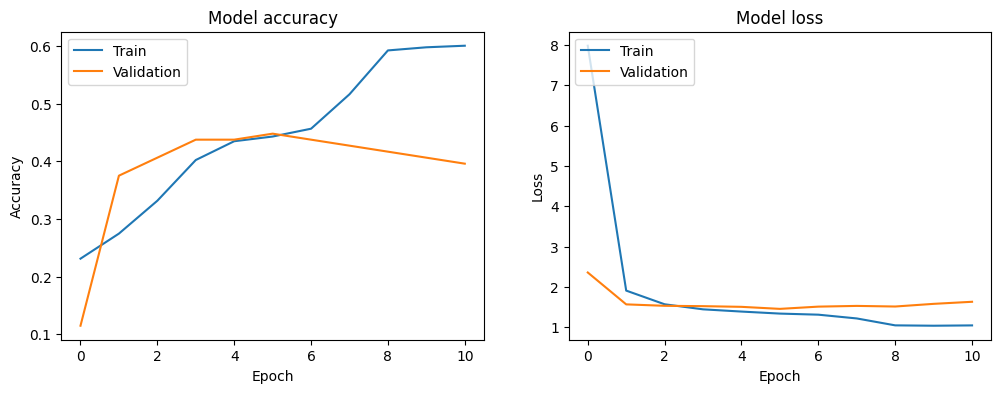

In [8]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Create the directory if it doesn't exist
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# Save the final model
model_path = os.path.join(MODEL_SAVE_DIR, 'heart_murmur_model.h5')
model.save(model_path)

print(f"Model saved successfully to {model_path}")